In [26]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# random
import warnings
warnings.filterwarnings('ignore')

In [27]:
# setting intial variables and constants
%config InlineBackend.figure_format='retina'

# graph Designs
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# loading in 
df = pd.read_csv('full_df.csv')

In [29]:
# looking at df
print(df.shape)
df.head()

(6607, 18)


,Unnamed: 0,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,text,Full_Address,City,Continent,Country,State,is_english
0,0,2008-03-28 14:15:51+00:00,778602262,-93.101503,44.950404,Importance of Human Intervantion,-0.042726,believer,male,-4.082745,aggressive,"on march 29, 2008 at 8 pm, make a statement ab...","{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",Saint Paul,North America,United States,Minnesota,True
1,1,2008-03-28 15:36:30+00:00,778649364,-117.164720,32.715710,Global stance,0.429441,believer,undefined,-0.132076,not aggressive,City looks at green building standards: Hoping...,"{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",San Diego,North America,United States,California,True
2,2,2008-03-28 15:41:13+00:00,778652293,-122.355847,37.788497,Weather Extremes,0.092446,neutral,male,-2.324198,not aggressive,@thiskat @agray @payload Snow? In PDX? In Marc...,"{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",San Francisco,North America,United States,California,True
3,3,2008-03-28 15:56:42+00:00,778661751,-123.033121,44.939157,Ideological Positions on Global Warming,-0.337010,denier,male,-4.810226,not aggressive,someone alert al gore - global warming isn't w...,"{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",Salem,North America,United States,Oregon,False
4,4,2008-03-28 16:09:12+00:00,778669248,-123.364953,48.428318,Weather Extremes,-0.317469,denier,male,-4.862617,not aggressive,It's snowing in Langford and sticking! It's t...,"{'ISO_3166-1_alpha-2': 'CA', 'ISO_3166-1_alpha...",Victoria,North America,Canada,British Columbia,True


In [30]:
# looking at sentiments 
pos = (df['sentiment'] > 0.5).sum()
neg = (df['sentiment'] < -0.5).sum()
neutral = len(df) - pos - neg
print(f'Positive: {pos} Negative: {neg} Neutral: {neutral}')

Positive: 1014 Negative: 1021 Neutral: 4572


In [31]:
# logic to create classes for sentiment
sentiment  = df["sentiment"]

conditions = [sentiment >= 0.5,
              sentiment <= -0.5,
              (sentiment >-0.5) & (sentiment <0.5)]
choices  = [2,0,1]

# create a new column in the DF based on the conditions
df["sentiment_score"] = np.select(conditions, choices, "ERROR")

In [32]:
# checking it out
df = df.drop('Unnamed: 0',axis=1)
df = df.drop('sentiment', axis=1)
df['sentiment_score'] = df['sentiment_score'].astype(int)
df.head()

,created_at,id,lng,lat,topic,stance,gender,temperature_avg,aggressiveness,text,Full_Address,City,Continent,Country,State,is_english,sentiment_score
0,2008-03-28 14:15:51+00:00,778602262,-93.101503,44.950404,Importance of Human Intervantion,believer,male,-4.082745,aggressive,"on march 29, 2008 at 8 pm, make a statement ab...","{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",Saint Paul,North America,United States,Minnesota,True,1
1,2008-03-28 15:36:30+00:00,778649364,-117.164720,32.715710,Global stance,believer,undefined,-0.132076,not aggressive,City looks at green building standards: Hoping...,"{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",San Diego,North America,United States,California,True,1
2,2008-03-28 15:41:13+00:00,778652293,-122.355847,37.788497,Weather Extremes,neutral,male,-2.324198,not aggressive,@thiskat @agray @payload Snow? In PDX? In Marc...,"{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",San Francisco,North America,United States,California,True,1
3,2008-03-28 15:56:42+00:00,778661751,-123.033121,44.939157,Ideological Positions on Global Warming,denier,male,-4.810226,not aggressive,someone alert al gore - global warming isn't w...,"{'ISO_3166-1_alpha-2': 'US', 'ISO_3166-1_alpha...",Salem,North America,United States,Oregon,False,1
4,2008-03-28 16:09:12+00:00,778669248,-123.364953,48.428318,Weather Extremes,denier,male,-4.862617,not aggressive,It's snowing in Langford and sticking! It's t...,"{'ISO_3166-1_alpha-2': 'CA', 'ISO_3166-1_alpha...",Victoria,North America,Canada,British Columbia,True,1


In [33]:
# preprocessing 

# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [34]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [35]:
# store length of each review 
token_lens = []

# iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 1.0, 'Review Token Count Graph')

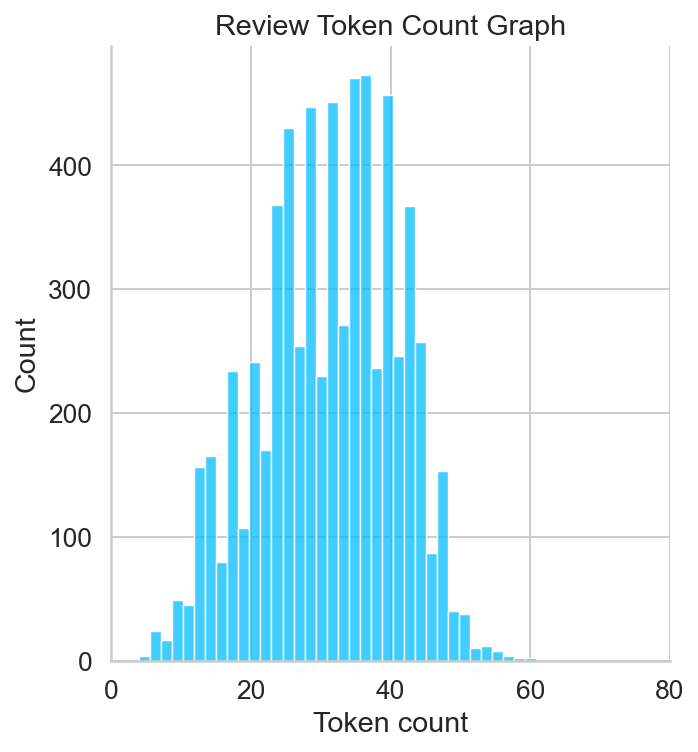

In [36]:
# plot the distribution of review lengths 
sns.displot(token_lens)
plt.xlim([0, 80]);
plt.xlabel('Token count')
plt.title('Review Token Count Graph')

In [37]:
class GPReviewDataset(Dataset):
    # constructor function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # length  method
    def __len__(self):
        return len(self.reviews)
    
    # get item  method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [38]:
# 80% train data and 10% test and 10% validation data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(5285, 17) (661, 17) (661, 17)


In [39]:
# dataloader to release data in batches
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.sentiment_score.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [40]:
# creating train, test and val data loaders
MAX_LEN = 160
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [41]:
# examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 160])
torch.Size([32, 160])
torch.Size([32])


In [42]:
# BERT sentiment classification 

# loading the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [43]:
# build the sentiment classifier class 
class SentimentClassifier(nn.Module):
    
    # constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # forward propagation class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [44]:
# instantiate the model and move to classifier
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [45]:
# num of hidden units
print(bert_model.config.hidden_size)

768


In [46]:
# num of iterations 
EPOCHS = 2

# adam as our optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [47]:
# function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())   
            
        # backward prop
        loss.backward()
        
        # gradient descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)


In [48]:
# function to evaluate performance
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
%%time

# training loop 
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")

    # get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # if we beat previous performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------


KeyboardInterrupt: 